In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
def load_data(file_path):
    return pd.read_csv(file_path, delim_whitespace=True, header=None)

# Wczytanie etykiet
def load_labels(file_path):
    return pd.read_csv(file_path, delim_whitespace=True, header=None)[0]

# Wczytanie danych treningowych i testowych
X_train = load_data('Samsung_HAR/samsung_HAR/samsung_train.txt')
y_train = load_labels('Samsung_HAR/samsung_HAR/samsung_train_labels.txt')
X_test = load_data('Samsung_HAR/samsung_HAR/samsung_test.txt')
y_test = load_labels('Samsung_HAR/samsung_HAR/samsung_test_labels.txt')

print("Kształt danych treningowych:", X_train.shape)
print("Kształt danych testowych:", X_test.shape)


C:\Users\wista\AppData\Local\Temp\ipykernel_29604\3835498414.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\wista\AppData\Local\Temp\ipykernel_29604\3835498414.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)[0]
C:\Users\wista\AppData\Local\Temp\ipykernel_29604\3835498414.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)


Kształt danych treningowych: (7352, 561)
Kształt danych testowych: (2947, 561)


C:\Users\wista\AppData\Local\Temp\ipykernel_29604\3835498414.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)[0]


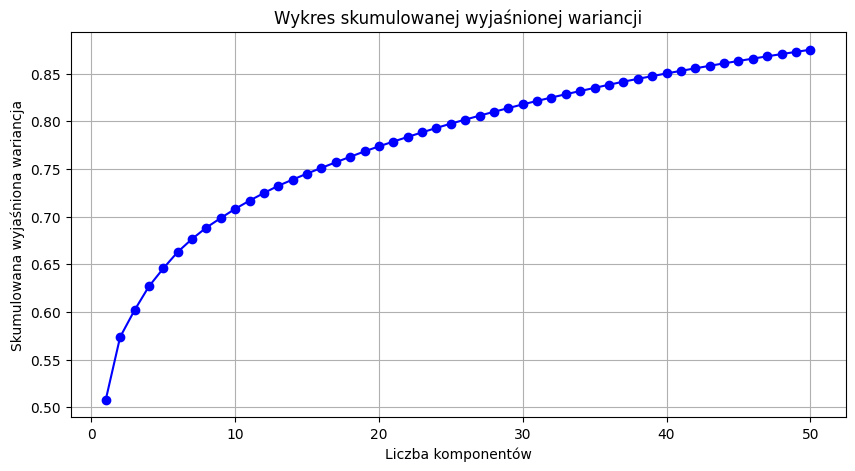

Wyjaśniona wariancja przez 50 komponentów: 87.52%


In [12]:
# Preprocessing danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=50)  # Zredukujmy wymiarowość do 50 komponentów
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Wyjaśniona wariancja
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres skumulowanej wyjaśnionej wariancji')
plt.grid(True)
plt.show()

print(f"Wyjaśniona wariancja przez 50 komponentów: {cumulative_variance_ratio[49]:.2%}")


In [13]:
# Przeprowadzenie klasteringu na zredukowanych danych
n_clusters = 6  # Liczba klas w oryginalnym zbiorze
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Dodanie wyników klasteringu jako nowych cech
X_train_with_clusters = np.column_stack((X_train_pca, train_clusters))
X_test_with_clusters = np.column_stack((X_test_pca, test_clusters))

# Funkcja do trenowania i oceny modelu z użyciem StratifiedKFold
def train_and_evaluate_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        score = accuracy_score(y_fold_val, y_pred)
        scores.append(score)
        print(f"Fold {fold} - Accuracy: {score:.4f}")
    
    print(f"\nŚrednia dokładność: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return np.mean(scores)

# Trenowanie i ocena Random Forest
print("\nRandom Forest:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_score = train_and_evaluate_model(rf_model, X_train_with_clusters, y_train)

# Trenowanie i ocena SVM
print("\nSVM:")
svm_model = SVC(kernel='rbf', random_state=42)
svm_score = train_and_evaluate_model(svm_model, X_train_with_clusters, y_train)

# Finalne trenowanie i ewaluacja na zbiorze testowym
if rf_score > svm_score:
    final_model = RandomForestClassifier(n_estimators=100, random_state=42)
    model_name = "Random Forest"
else:
    final_model = SVC(kernel='rbf', random_state=42)
    model_name = "SVM"

final_model.fit(X_train_with_clusters, y_train)
y_pred = final_model.predict(X_test_with_clusters)

print(f"\nWyniki końcowe dla {model_name} na zbiorze testowym:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Random Forest:
Fold 1 - Accuracy: 0.9327
Fold 2 - Accuracy: 0.9245
Fold 3 - Accuracy: 0.9238
Fold 4 - Accuracy: 0.9211
Fold 5 - Accuracy: 0.9156

Średnia dokładność: 0.9236 (+/- 0.0055)

SVM:
Fold 1 - Accuracy: 0.9456
Fold 2 - Accuracy: 0.9538
Fold 3 - Accuracy: 0.9531
Fold 4 - Accuracy: 0.9476
Fold 5 - Accuracy: 0.9456

Średnia dokładność: 0.9491 (+/- 0.0036)

Wyniki końcowe dla SVM na zbiorze testowym:

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.95      0.94       496
           2       0.86      0.92      0.89       471
           3       0.97      0.86      0.91       420
           4       0.88      0.85      0.86       491
           5       0.88      0.92      0.90       532
           6       1.00      0.97      0.98       537

    accuracy                           0.92      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.92      0.92      2947

